In [1]:
from zeroinflated_Poisson import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
from Utils.eval import multiProc_eval,plotAUC
from tensorflow.keras.optimizers import Adam
import keras.backend.tensorflow_backend
from keras.backend import clear_session
from tensorflow.keras.models import Model,Sequential

Num GPUs: 1


Using TensorFlow backend.


In [2]:
source_model,modelpath,train,test = getModel(False)
source_model.summary()
predictions = source_model.layers[-2].output
model = Model(inputs=source_model.inputs, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 10)   460         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 10)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 10)   0           activation[0][0]                 
______________________________________________________________________________________________

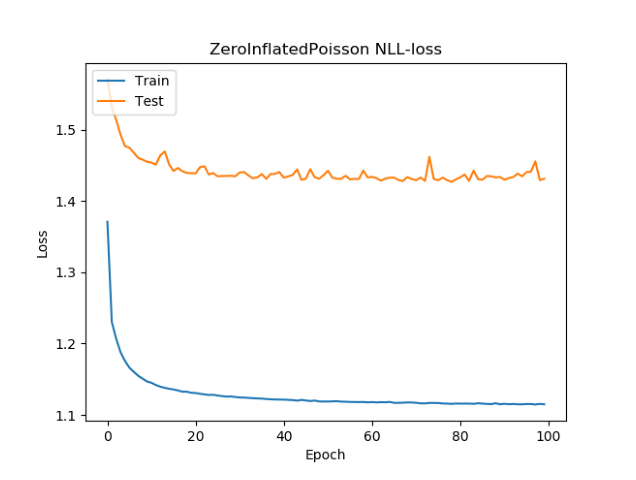

In [3]:
history_path = os.path.join(modelpath,MODELNAME+"_history.png")
figure(num=None, figsize=(10, 30), dpi=80, facecolor='w', edgecolor='k')
loss = np.array(Image.open(history_path))
plt.imshow(loss)
plt.axis('off')
plt.show()
history_path = os.path.join(modelpath,MODELNAME+"_history")
laststate = getBestState(modelpath,history_path)
epoch = laststate["epoch"]
model.load_weights(laststate["modelpath"])
test.setWiggle_off()

In [4]:
def getFreshSet(batch_size=1):
    x_transform = [Normalize(0.007742631458799244, 0.015872015890555563 )]
    
    train,test = getData(batch_size,
                         DIMENSION,CHANNELS,
                         timeToPred=10,
                         x_transform=x_transform)
    return train,test

In [5]:
from Models.Distributions import ZeroInflated_Poisson
pred = None
label = None
pred = 20
#test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
train,test = getFreshSet(50)
test.on_epoch_end()
test.setWiggle_off()
atm = []
for x,y in test:
    for i in range(BATCH_SIZE):
        if y[i,:,:,:].max() >= 0:
            pred = model(np.array([x[i,:,:,:]]))
            pred = ZeroInflated_Poisson()(pred)
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            atm.append(x[i,:,:,-1:])
            if len(label) == 20:
                break
        break
    if len(label) == 20:
                break

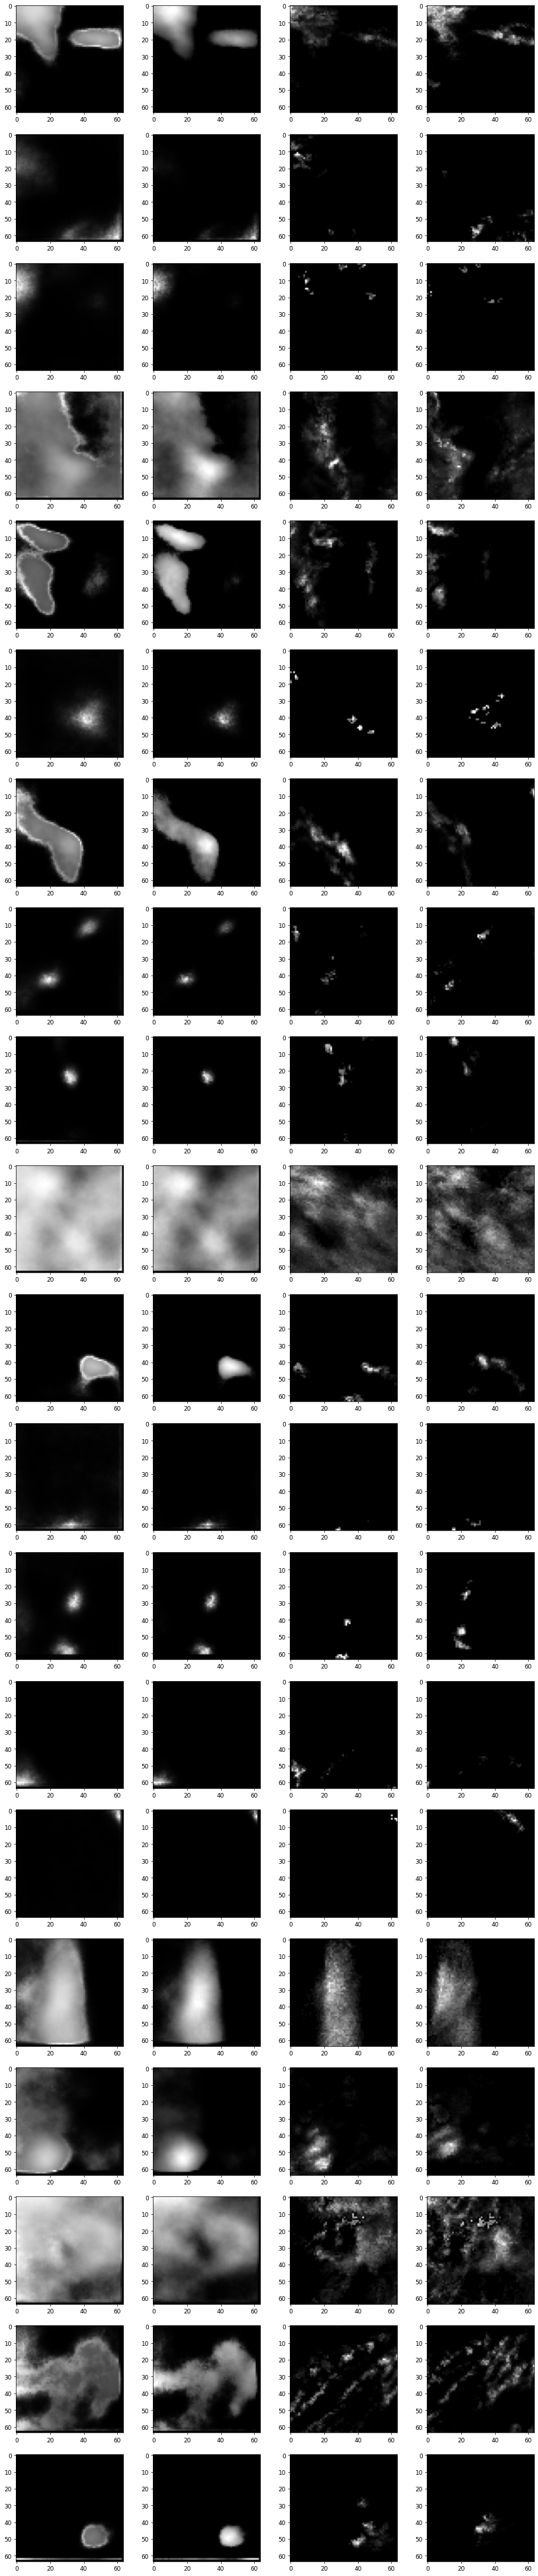

In [6]:
fig, axes = plt.subplots(20, 4, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")
    axes[batch,3].imshow(atm[batch][:,:,0],cmap="gray")
plt.show()

In [ ]:
def zPoisson(t):

    return tfp.distributions.Independent(tfd.Mixture(
                                  cat=tfd.Categorical(tf.stack([1-t[...,:1], t[...,:1]],axis=-1)),
                                  components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
                                  tfd.Poisson(rate=tf.math.softplus(t[...,1:2]))])
                              ,name="ZeroInflated",reinterpreted_batch_ndims=0 )

baseline = multiProc_eval(model,test,getFreshSet,dist = zPoisson)

Worker  1 finishedd   1800 imagesing to sleep for 5s
Worker  2 finishedd   1800 images
Worker  3 finishedd   1800 images
Worker  4 finishedd   1800 images
Worker  0 finishedd   1800 images
Worker  5 finishedd   1800 images
Worker  6 finishedd   1800 images
Worker  7 finishedd   1800 images
Worker  8 finishedd   1800 images
Worker 11 finishedd   1800 images
Worker  9 finishedd   1800 images
Worker 10 finishedd   1800 images
Worker 12 finishedd   1800 images
Worker 14 finishedd   1800 images
Worker 13 finishedd   1800 images
Worker 16 finishedd   1800 images
Worker 15 finishedd   1800 images
Worker 17 finishedd   1800 images
Worker 18 finishedd   1800 images
Worker 19 finishedd   1800 images
Worker 21 finishedd   1800 images
Worker 20 finishedd   1800 images
Worker 22 finishedd   1800 images


In [ ]:
baseline_dict = baseline.copy()

In [ ]:
plotAUC(baseline_dict)